# Sentiment analysis for RNN by Keras

In [1]:
import numpy as np
import tensorflow as tf
import sys
import string
import json

from numpy import array
from keras.preprocessing.text import one_hot
from keras.layers import Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, LSTM, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.layers.core import Activation, Dropout 

from keras.callbacks import ModelCheckpoint

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from operator import itemgetter

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


## Load data

In [5]:
def load_data(data_file=None):
    if data_file == None:
        return
    with open(data_file) as f:
        data = json.load(f)
    return data

In [6]:
folder = './data/large_files/stanford_sentiment/parsed_data/'
word2idx = load_data(folder + "sentiment_word2idx.json")
sentiment_binary_train = load_data(folder + "sentiment_binary_train.json")
sentiment_train = load_data(folder + "sentiment_train.json")
sentiment_binary_test = load_data(folder + "sentiment_binary_test.json")
sentiment_test = load_data(folder + "sentiment_test.json")

### Exclude neutral samples

* The loaded samples has three type of labels -1,0,1, in which -1 indicates neutral sentiment.
* We exclude samples with neutral sentiment.

In [7]:
# the loaded samples has three type of labels -1,0,1, in which -1 indicates neutral sentiment.
# We exclude samples with neutral sentiment.
def exclude_neutral_sample(samples:dict):
    ssamples = {}
    for k, v in samples.items():
        if v[3][-1] != -1:
            ssamples[k] = v
    return ssamples
        
train_b = exclude_neutral_sample(sentiment_binary_train)
test_b = exclude_neutral_sample(sentiment_binary_test)

print("After filtering: # of training samples and # of test samples")
print("# of traing samples: ", len(train_b))
print("# of test samples: ", len(test_b))

After filtering: # of training samples and # of test samples
# of traing samples:  6920
# of test samples:  1821


### Convert training/test data to sentences
* Currently, the training/test data are in the form of integer sequences, which are directly parsed from Stanford sentimental analysis raw data. We have not done any preprocessing on those data yet. 
* The purpose of coverting training/test data into sentences is that we will do some preprocessing on these sentences. Then, we will convert sentences back to integer sequences.

In [8]:
def get_comment(wordidx, idx2word:dict):
    wordlist = []
    for idx in wordidx:
        if idx != -1:
            token = idx2word[idx]
            if token not in string.punctuation:
                wordlist.append(token)
    return wordlist

# Convert training/test examples to the form that each example is list of words (including punctation).
# Also construct the targets for each example.
def get_comments_samples(samples:dict, idx2word:dict):
    comments = []
    targets = []
    for _, v in samples.items():
        if v[3][-1] != -1:
            comment = " ".join(get_comment(v[0], idx2word))
            label = v[3][-1]
            comments.append(comment)
            targets.append(label) 
    return comments, targets

In [9]:
idx2word = {v:k for k, v in word2idx.items()}
train_comments_o, train_targets = get_comments_samples(train_b, idx2word)
test_comments_o, test_targets = get_comments_samples(test_b, idx2word)

vocabulary_size = len(idx2word)
print('vocabulary_size' , vocabulary_size)

vocabulary_size 18647


In [10]:
# Test: just see the split of training data in terms of label

count0 = 0
count1 = 0
count2 = 0
for i in range(len(train_comments_o)):

    if train_targets[i] == 0:
        count0 += 1
    elif train_targets[i] == 1:
        count1 += 1
    else:
        count2 += 1
    
print("0", count0)
print("1", count1)
print("-1", count2)

0 3310
1 3610
-1 0


## Preprocessing and analyzing data

### Preprocessing data
* Remove stopwords
* Remove punctuation
* Tokenization
* Change the representation of training/test data to integer

In [11]:
def remove_punctuation(samples):
    filtered_samples = []
    for i in samples:
        filtered_samples.append(i.translate(str.maketrans('', '', string.punctuation)))
    return filtered_samples

In [12]:
def tokenize(samples):
    tokenized_samples = []
    for s in samples:
        tokens = word_tokenize(s)
        tokenized_samples.append(tokens)
    return tokenized_samples

In [13]:
# default stopwords set from NLTK
stopWords = set(stopwords.words('english'))
print(stopWords)

{'but', 'so', "isn't", 'doesn', 'between', 'shan', 'other', 'then', 'each', 'aren', 'ma', 'about', 'him', 'won', 'them', 'her', 'did', 'when', "haven't", 'we', "you're", "that'll", 'out', 'over', 'theirs', 'after', 'down', "needn't", 'an', 'a', 'this', 'am', "hasn't", 'of', 'until', 'to', 'wasn', 'against', 'yourself', 'by', 'above', 'off', 'now', 'while', "don't", "wouldn't", 've', 'be', 'at', 'itself', "you'd", 'll', 'yours', "you'll", 'me', 'through', 'for', 'himself', 'couldn', 'ain', 'which', "couldn't", "she's", 'your', 'hasn', 'and', "wasn't", 'because', 'where', 'those', 'whom', 'under', 'he', 'up', 'wouldn', 'doing', 'i', 'you', 'what', 'no', 'does', 'our', 'can', 'had', 'isn', 'didn', 'having', 'it', 't', 'too', 'both', 'during', 'in', 'from', 'myself', 'before', 'than', 'some', 'mightn', 're', "shan't", 'ourselves', "hadn't", 'his', "aren't", "doesn't", 'not', "it's", 'my', 'these', 'o', 'being', 'shouldn', 'hers', 'the', 'below', 'was', 'here', 'again', 'with', 'own', "won'

In [14]:
# stopwords version 1: exclude negation words from the stopwords set
stopWords_revised = set(('at', 'how', 'each', 's', 'those', 'from','whom', 'if', 're', 'we', 'by','into', 'it', 'ma', 'than', "you'll", 
             'very', 'was', 'is', 'be', 'had', 'you', 'hers', 'off', 'her', 'your', 'other', 'on', 'down', 'its', 'should', 
             'which', 'now', 'ours', 'in', "you've", 'before', 'further', 'below', 'did',  'who', 'once', 'some', 'being', 
             'does', 'too', 'herself', 'about', 'my', 'are', 'during', 'few', 'an', 'do', 'over',  'themselves', 'the', 'why', 'a', 'same', 'all', 
             'own', 'with', 'under', 'myself', 'he', 'because', 'again', 'himself', 'these', 'that', 'am', 'through', 'll', 'so', 've', "you're", 'doing', 'between', 
             'when', 'ourselves', 'been', 'of', 'our', 'them', 'their', 'while', 'as', 'can', 'where', 'such', 'yourself', 'haven', 'they', 'theirs', 'm', 'both', 
                     "that'll", 'or', 'were', 'up', 'will', 'me', 'yours', 'itself', 'has', 'more', 
                'd', 'o', 'what', 'having', 't', 'this', 'after', 'then', 'above', 'out', 'nor', "should've", 'his', 
               "you'd", "she's", 'and', 'shan', 'until', 'here', 'for', 'just', 'him', 'to', 'have', 'she', 'yourselves', "it's", 'y', 'i', 'there'))


In [15]:
# stopwords version 2: exclude negation words and some comparision words from the stopwords set
stopWords_revised_2 = set(('at', 'each', 's', 'those', 'from', 'if', 're', 'we', 'by','into', 'it', 'ma', "you'll", 
             'very', 'was', 'is', 'be', 'had', 'you', 'hers', 'off', 'her', 'your', 'other', 'on', 'down', 'its', 'should', 
              'now', 'ours', 'in', "you've", 'below', 'did', 'being', 
             'does', 'herself', 'about', 'my', 'are', 'an', 'do', 'themselves', 'the',  'a',  
             'own', 'myself', 'he',  'himself', 'these', 'that', 'am', 'll', 'so', 've', "you're", 'doing', 
            'ourselves', 'been', 'of', 'our', 'them', 'their', 'can', 'yourself', 'they', 'theirs', 'm', 
                     "that'll", 'or', 'were', 'up', 'will', 'me', 'yours', 'itself', 'has', 
                'd', 'o', 'having', 't', 'this', 'after', 'then', 'out', "should've", 'his', 
               "you'd", "she's", 'shan',  'here', 'for', 'him', 'to', 'have', 'she', 'yourselves', "it's", 'y', 'i', 'there'))


In [16]:
def remove_stopwords(samples):
    filtered_samples = []
    for s in samples:
        filstered_tokens = []
        for w in s:
            if w not in stopWords_revised_2:
                filstered_tokens.append(w)
        filtered_samples.append(filstered_tokens)
    return filtered_samples  

In [17]:
# Test
# for i in range(100):
#     print(i, ": ", train_comments_o[i])

In [18]:
train_comments_1 = []
for comment in train_comments_o:
    new_str = comment.replace("n't", 'not')
    train_comments_1.append(new_str)
    
test_comments_1 = []
for comment in test_comments_o:
    new_str = comment.replace("n't", 'not')
    test_comments_1.append(new_str)

In [19]:
# Test
# for i in range(100):
#     print(i, ": ", train_comments_1[i])

In [20]:
train_comments_punc = remove_punctuation(train_comments_1)
test_comments_punc = remove_punctuation(test_comments_1)
print("punctuation removed")

punctuation removed


In [21]:
# Test
# for i in range(100):
#     print(i, ": ", train_comments_punc[i])

In [22]:
train_comments_tokenized = tokenize(train_comments_punc)
test_comments_tokenized = tokenize(test_comments_punc)
print("tokenized")

tokenized


In [23]:
# Test
# for i in range(100):
#     print(i, ": ", train_comments_tokenized[i])

In [24]:
train_comments_stopwords = remove_stopwords(train_comments_tokenized)
test_comments_stopwords = remove_stopwords(test_comments_tokenized)
print("stopwords removed")

stopwords removed


In [25]:
# Test
# for i in range(100):
#     print(i, ": ", train_comments_stopwords[i])

### Convert training/test data in the form of sentences into integer sequences

In [26]:
# combine all the comments to gather all the words for the vocabulary
def combine(tokenized_comments):
    text = []
    for comment in tokenized_comments:
        text += comment
    return text

all_words = combine(train_comments_stopwords) + combine(test_comments_stopwords)

In [27]:
# Create your dictionary that maps vocab words to integers here
from collections import Counter
counts = Counter(all_words)
print(type(counts))

vocab = sorted(counts, key=counts.get, reverse=True)

# Create words-to-index map. 
# Note that index start from 1
vocab_to_int = {word:i for i, word in enumerate(vocab, 1)}

<class 'collections.Counter'>


In [28]:
print("type of vocab", type(vocab))
print('total # of words: ', len(vocab_to_int))
print("first word:", vocab[0])
print("last word:", vocab[-1])
print("first word index:", vocab_to_int[vocab[0]])
print("last word index", vocab_to_int[vocab[-1]])

type of vocab <class 'list'>
total # of words:  16547
first word: and
last word: hired
first word index: 1
last word index 16547


In [29]:
# Create index-to-words map.
index2word = {idx:word for word, idx in vocab_to_int.items()}

In [30]:
def convert_to_int(reviews, vocab_to_int):
    # Convert the reviews to integers, same shape as reviews list, but with integers
    print('# of reviews before index: ', len(reviews))
    reviews_ints = []
    for review in reviews:
        reviews_ints.append([vocab_to_int[word] for word in review])

    print('# of reviews after index: ', len(reviews_ints))
    return reviews_ints

In [31]:
# convert the representation of training examples from text to integer
x_train = convert_to_int(train_comments_stopwords, vocab_to_int)

# of reviews before index:  6920
# of reviews after index:  6920


In [32]:
# Test
print(x_train[7])
print(train_comments_o[7])
text = [index2word[idx] for idx in x_train[7]]
print(text)

[428, 1555, 2686, 612, 5786, 645]
visually santa clause 2 is wondrously creative
['visually', 'santa', 'clause', '2', 'wondrously', 'creative']


In [33]:
# convert the representation of test examples from text to integer
x_test = convert_to_int(test_comments_stopwords, vocab_to_int)

# of reviews before index:  1821
# of reviews after index:  1821


### Calculate/analyze distribution over training/test example lengths
* The purpose for this analysis is to find the best `maximum sequence length` for padding

In [34]:
from collections import Counter

# Create length to frequency map
x_train_lens_map = Counter([len(x) for x in x_train])
x_train_lens = [len(x) for x in x_train]
print("Zero-length reviews: {}".format(x_train_lens_map[0]))
print("Maximum train example length: {}".format(max(x_train_lens_map)))
print("Maximum train example length: {}".format(x_train_lens_map[-1]))
print(x_train_lens_map)

Zero-length reviews: 2
Maximum train example length: 36
Maximum train example length: 0
Counter({10: 465, 9: 454, 6: 436, 11: 434, 12: 432, 13: 422, 8: 414, 7: 398, 14: 368, 15: 338, 5: 335, 4: 331, 16: 286, 17: 259, 3: 252, 18: 238, 19: 189, 2: 187, 20: 140, 21: 124, 22: 86, 23: 83, 1: 54, 24: 53, 25: 53, 26: 29, 27: 23, 28: 11, 30: 9, 29: 8, 31: 3, 0: 2, 32: 2, 33: 1, 36: 1})


In [35]:
# Create length to frequency map
x_test_lens_map = Counter([len(x) for x in x_test])
x_test_lens = [len(x) for x in x_test]
print("Zero-length reviews: {}".format(x_test_lens_map[0]))
print("Maximum test example length: {}".format(max(x_test_lens_map)))

ave_len = 0
for i in x_train:
    ave_len += len(i) 
ave_len = ave_len / len(x_train)
print(ave_len)

ave_len = 0
for i in x_test:
    ave_len += len(i)  
ave_len = ave_len / len(x_test)
print(ave_len)

Zero-length reviews: 0
Maximum test example length: 31
11.324566473988439
11.314662273476111


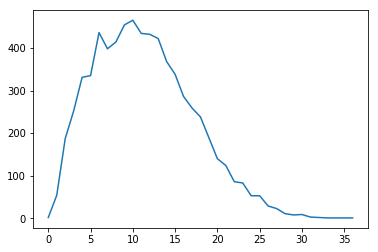

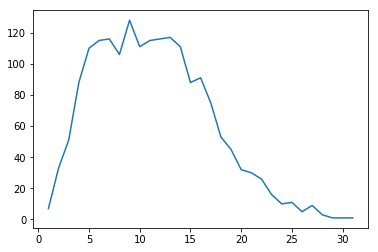

In [37]:
import matplotlib.pyplot as plt
plt.plot(list(x_train_lens_map.keys()), list(x_train_lens_map.values()))
# plt.axis([1000, 1500, 0, 55])
plt.show()

plt.plot(list(x_test_lens_map.keys()), list(x_test_lens_map.values()))
# plt.axis([1000, 1500, 0, 55])
plt.show()

We tried different lengths as the maximum sequence length, 36 gives us best result for now.  

### Padding

In [38]:
def left_padding(reviews_ints, seq_len):
    
    # The features created here are the data that we are going to train and test the network

    # Create features with shape (len(reviews_ints), seq_len) and initialized with zeros
    features = np.zeros((len(reviews_ints), seq_len), dtype=int)

    print(features.shape)
    # Create list holding the length for each review
    lengths = []

    # row is the review in forms of a list of integers
    for i, row in enumerate(reviews_ints):

        # left padding
        features[i, -len(row):] = np.array(row)[:seq_len]
        
        # record the length of each review. This might be useful when we want to use sequence_length argument
        # of tf.nn.dynamic_rnn(...)
        lengths.append(len(row) if len(row) < seq_len else seq_len)
        
    return features, lengths

In [39]:
# Test

# sample1 = [4,6,7,2,3,5,7,8,1]
# sample2 = [1,2,3,4,6,7,2,3,5,7]
# sample3 = [1,2,3,4,6,7,2,3,26,1, 11, 12]
# sample4 = [8,7,3]
# samples = []
# samples.append(sample1)
# samples.append(sample2)
# samples.append(sample3)
# samples.append(sample4)
# features_, lengths_ = left_padding(samples, 12)

# print(features_)
# print(lengths_)

In [40]:
# Exclude training/test examples with 0 length. It is possible that some examples may have 0 length since we did 
# punctuation and stopword removing. 
x_train_f = []
y_train_f = []
for idx in range(len(x_train)):
    if len(x_train[idx]) != 0:
        x_train_f.append(x_train[idx])
        y_train_f.append(train_targets[idx])

x_test_f = []
y_test_f = []
for idx in range(len(x_test)):
    if len(x_test[idx]) != 0:
        x_test_f.append(x_test[idx])
        y_test_f.append(test_targets[idx])

In [41]:
# perform padding
train_seq_len = 36
test_seq_len = 31
x_train_p, x_train_len = left_padding(x_train_f, train_seq_len)
x_test_p, x_test_len = left_padding(x_test_f, train_seq_len)

(6918, 36)
(1821, 36)


In [44]:
# Test

x_train_p[:5,:train_seq_len]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
        10263,   449,   961,   380,    41,   546,     1,  5586,   690],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0, 11967,   365,
         1896,  2664,  7113,  1349,  3363,  8490,     1, 10225,   146],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,  2383,   285,  7139],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
   

In [45]:
# Add more data for training, since RNN consumes lots of data
x_train_ = np.append(x_train_p, x_test_p[:1086], axis=0)
x_test_ = x_test_p[1086:]

y_train_ = np.array(np.append(y_train_f, y_test_f[:1086], axis=0))
y_test_ = np.array(y_test_f[1086:])

x_train_len_ = np.append(x_train_len, x_test_len[:1086], axis=0)
x_test_len_ = x_test_len[1086:]

print(len(x_train_))
print(len(x_test_))
print(len(y_train_))
print(len(y_test_))
print(len(x_train_len_))
print(len(x_test_len_))

8004
735
8004
735
8004
735


In [46]:
# print(x_train_.shape)
# print(x_test_.shape)
# print(y_train_.shape)
# print(y_test_.shape)

In [62]:
def LSTM_model(input_shape, vocab_size, embedding_dim=256, rnn_units=128, dropout_prob=0.8):
    """
    :param input_shape: Tuple of input shape
    :param vocab_size: Number of unique English words in the dataset
    :return: Keras model built, but not trained
    """
    model = Sequential()
    # Embedding layer
    model.add(Embedding(vocab_size, embedding_dim, input_shape=input_shape[1:]))
    # Encoder with bidirectional RNN
    model.add(LSTM(rnn_units, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_prob))  
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # checkpoint
    filepath="weights.best.hdf5"
#     filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    return model, callbacks_list

In [63]:
def BiLSTM_model(input_shape, vocab_size, embedding_dim=256, rnn_units=128, dropout_prob=0.8):
    """
    :param input_shape: Tuple of input shape
    :param vocab_size: Number of unique English words in the dataset
    :return: Keras model built, but not trained
    """
    model = Sequential()
    # Embedding layer
    model.add(Embedding(vocab_size, embedding_dim, input_shape=input_shape[1:]))
    # Encoder with bidirectional RNN
    model.add(Bidirectional(LSTM(rnn_units, activation='relu', return_sequences=False)))
    model.add(Dropout(dropout_prob))  
    model.add(Dense(1, activation='sigmoid'))
    
    # checkpoint
    filepath="weights.best.hdf5"
#     filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model, callbacks_list

In [64]:
vocab_size = len(vocab_to_int) + 1

# Grid Search for "best" model
# embedding_dims = [256, 300]
embedding_dims = [256]
rnn_units = [128, 256]
dropout_probs = [0.7, 0.8]
using_biLSTM = False

for e in embedding_dims:
    for r in rnn_units:
        for d in dropout_probs:
            print("---------------------------------------------------------------------")
            print("e", e)
            print("r", r)
            print("d", d)
            
            # test LSTM, BiLSTM
            if using_biLSTM:
                print('Using BiLSTM')
                custom_rnn_model, callbacks_list = BiLSTM_model(x_train_.shape, vocab_size, e, r, d)
            else:
                print('Using LSTM')
                custom_rnn_model, callbacks_list = LSTM_model(x_train_.shape, vocab_size, e, r, d)
            print(custom_rnn_model.summary())
            custom_rnn_model.fit(x_train_, y_train_, batch_size=400, epochs=10, validation_split=0.1, callbacks=callbacks_list,)
            print(custom_rnn_model.metrics_names)
            
            custom_rnn_model.load_weights("weights.best.hdf5")
            custom_rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            result = custom_rnn_model.evaluate(x=x_test_, y=y_test_, batch_size=200)
            print(result)

---------------------------------------------------------------------
e 256
r 128
d 0.7
Using LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 36, 256)           4236288   
_________________________________________________________________
lstm_29 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 129       
Total params: 4,433,537
Trainable params: 4,433,537
Non-trainable params: 0
_________________________________________________________________
None
Train on 7203 samples, validate on 801 samples
Epoch 1/10
7203/7203 [==============================] - 22s 3ms/step - loss: 0.6895 - acc: 0.5227 - val_loss: 0.6

Epoch 5/10
7203/7203 [==============================] - 25s 3ms/step - loss: 0.2024 - acc: 0.9500 - val_loss: 0.4522 - val_acc: 0.7978

Epoch 00005: val_acc did not improve from 0.82272
Epoch 6/10
7203/7203 [==============================] - 29s 4ms/step - loss: 0.1489 - acc: 0.9731 - val_loss: 0.8003 - val_acc: 0.8077

Epoch 00006: val_acc did not improve from 0.82272
Epoch 7/10
7203/7203 [==============================] - 27s 4ms/step - loss: 0.0765 - acc: 0.9833 - val_loss: 0.5427 - val_acc: 0.7865

Epoch 00007: val_acc did not improve from 0.82272
Epoch 8/10
7203/7203 [==============================] - 24s 3ms/step - loss: 0.0518 - acc: 0.9875 - val_loss: 0.8939 - val_acc: 0.7790

Epoch 00008: val_acc did not improve from 0.82272
Epoch 9/10
7203/7203 [==============================] - 26s 4ms/step - loss: 0.0313 - acc: 0.9908 - val_loss: 0.9980 - val_acc: 0.7915

Epoch 00009: val_acc did not improve from 0.82272
Epoch 10/10
7203/7203 [==============================] - 24s 3ms/step 